In [1]:
import numpy as np
import matplotlib.pyplot as plt
from esn import ESN

In [2]:
# NARMAモデルのパラメータ
n = 10
a1, a2, a3, a4 = 0.3, 0.05, 1.5, 0.1
T = 1000  # データ長
d = [0]*n

np.random.seed(seed=0)

# 時系列入力データ生成
u = np.random.uniform(0, 0.5, T)
u = u.reshape(-1, 1)

# 時系列目標データ作成
for i in range(n, T):
    d_n = a1 * d[-1] + a2 * d[-1] * np.sum(d[-n:]) + a3 * u[i - n] * u[i - 1] + a4
    d.append(d_n)
d = np.array(d)

# データ分割
u_train, u_test = u[n*2:T//2], u[T//2-n*2:]
d_train, d_test = d[n*2:T//2], d[T//2-n*2:]

C:\Users\yoshi\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\yoshi\AppData\Local\Temp\ipykernel_14188\3274239289.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  d = np.array(d)


In [3]:
# ESNのハイパーパラメータ設定
N_u = 1
N_x = 3000
input_scale = 1
leaking_rate = 0.9
activation_func = np.tanh
rho = 0.9
rec_scale = 1.0
seed = 0

# ESNインスタンスの作成
esn = ESN(N_u, N_x, input_scale, rec_scale, rho, leaking_rate, activation_func, seed)

In [4]:
# 学習データでのリザバー状態計算
stateCollectMat_train = esn.compute_reservoir_states(u_train)

# テストデータでのリザバー状態計算
stateCollectMat_test = esn.compute_reservoir_states(u_test)

# リードアウト重みの学習
Wout_random = np.random.uniform(-0.03, 0.03, N_x) # 未学習のリードアウト重み
Wout = esn.train(stateCollectMat_train, d_train)

# 学習データでの予測（未学習重み使用）
Y_pred_train_random = np.dot(Wout_random, stateCollectMat_train.T)

# 学習データでの予測（学習済み重み使用）
Y_pred_train = esn.predict(Wout, stateCollectMat_train)

# テストデータでの予測
Y_pred_test = esn.predict(Wout, stateCollectMat_test)

Computing Reservoir States: 100%|████████████████████████████████| 520/520 [00:01<00:00, 510.38it/s]


In [5]:
# 評価（RMSE, NRMSE）
RMSE_train = np.sqrt(((d_train[-100:] - Y_pred_train[-100:]) ** 2).mean())
NRMSE_train = RMSE_train / np.sqrt(np.var(d_train[-100:]))
RMSE_test = np.sqrt(((d_test[n*2:100+n*2] - Y_pred_test[n*2:100+n*2]) ** 2).mean())
NRMSE_test = RMSE_test / np.sqrt(np.var(d_test[n*2:100+n*2]))

print("Train RMSE =", RMSE_train)
print("Train NRMSE =", NRMSE_train)
print("Test RMSE =", RMSE_test)
print("Test NRMSE =", NRMSE_test)

Train RMSE = [2.44937061e-14]
Train NRMSE = [2.3206495e-13]
Test RMSE = [0.02622735]
Test NRMSE = [0.25336738]


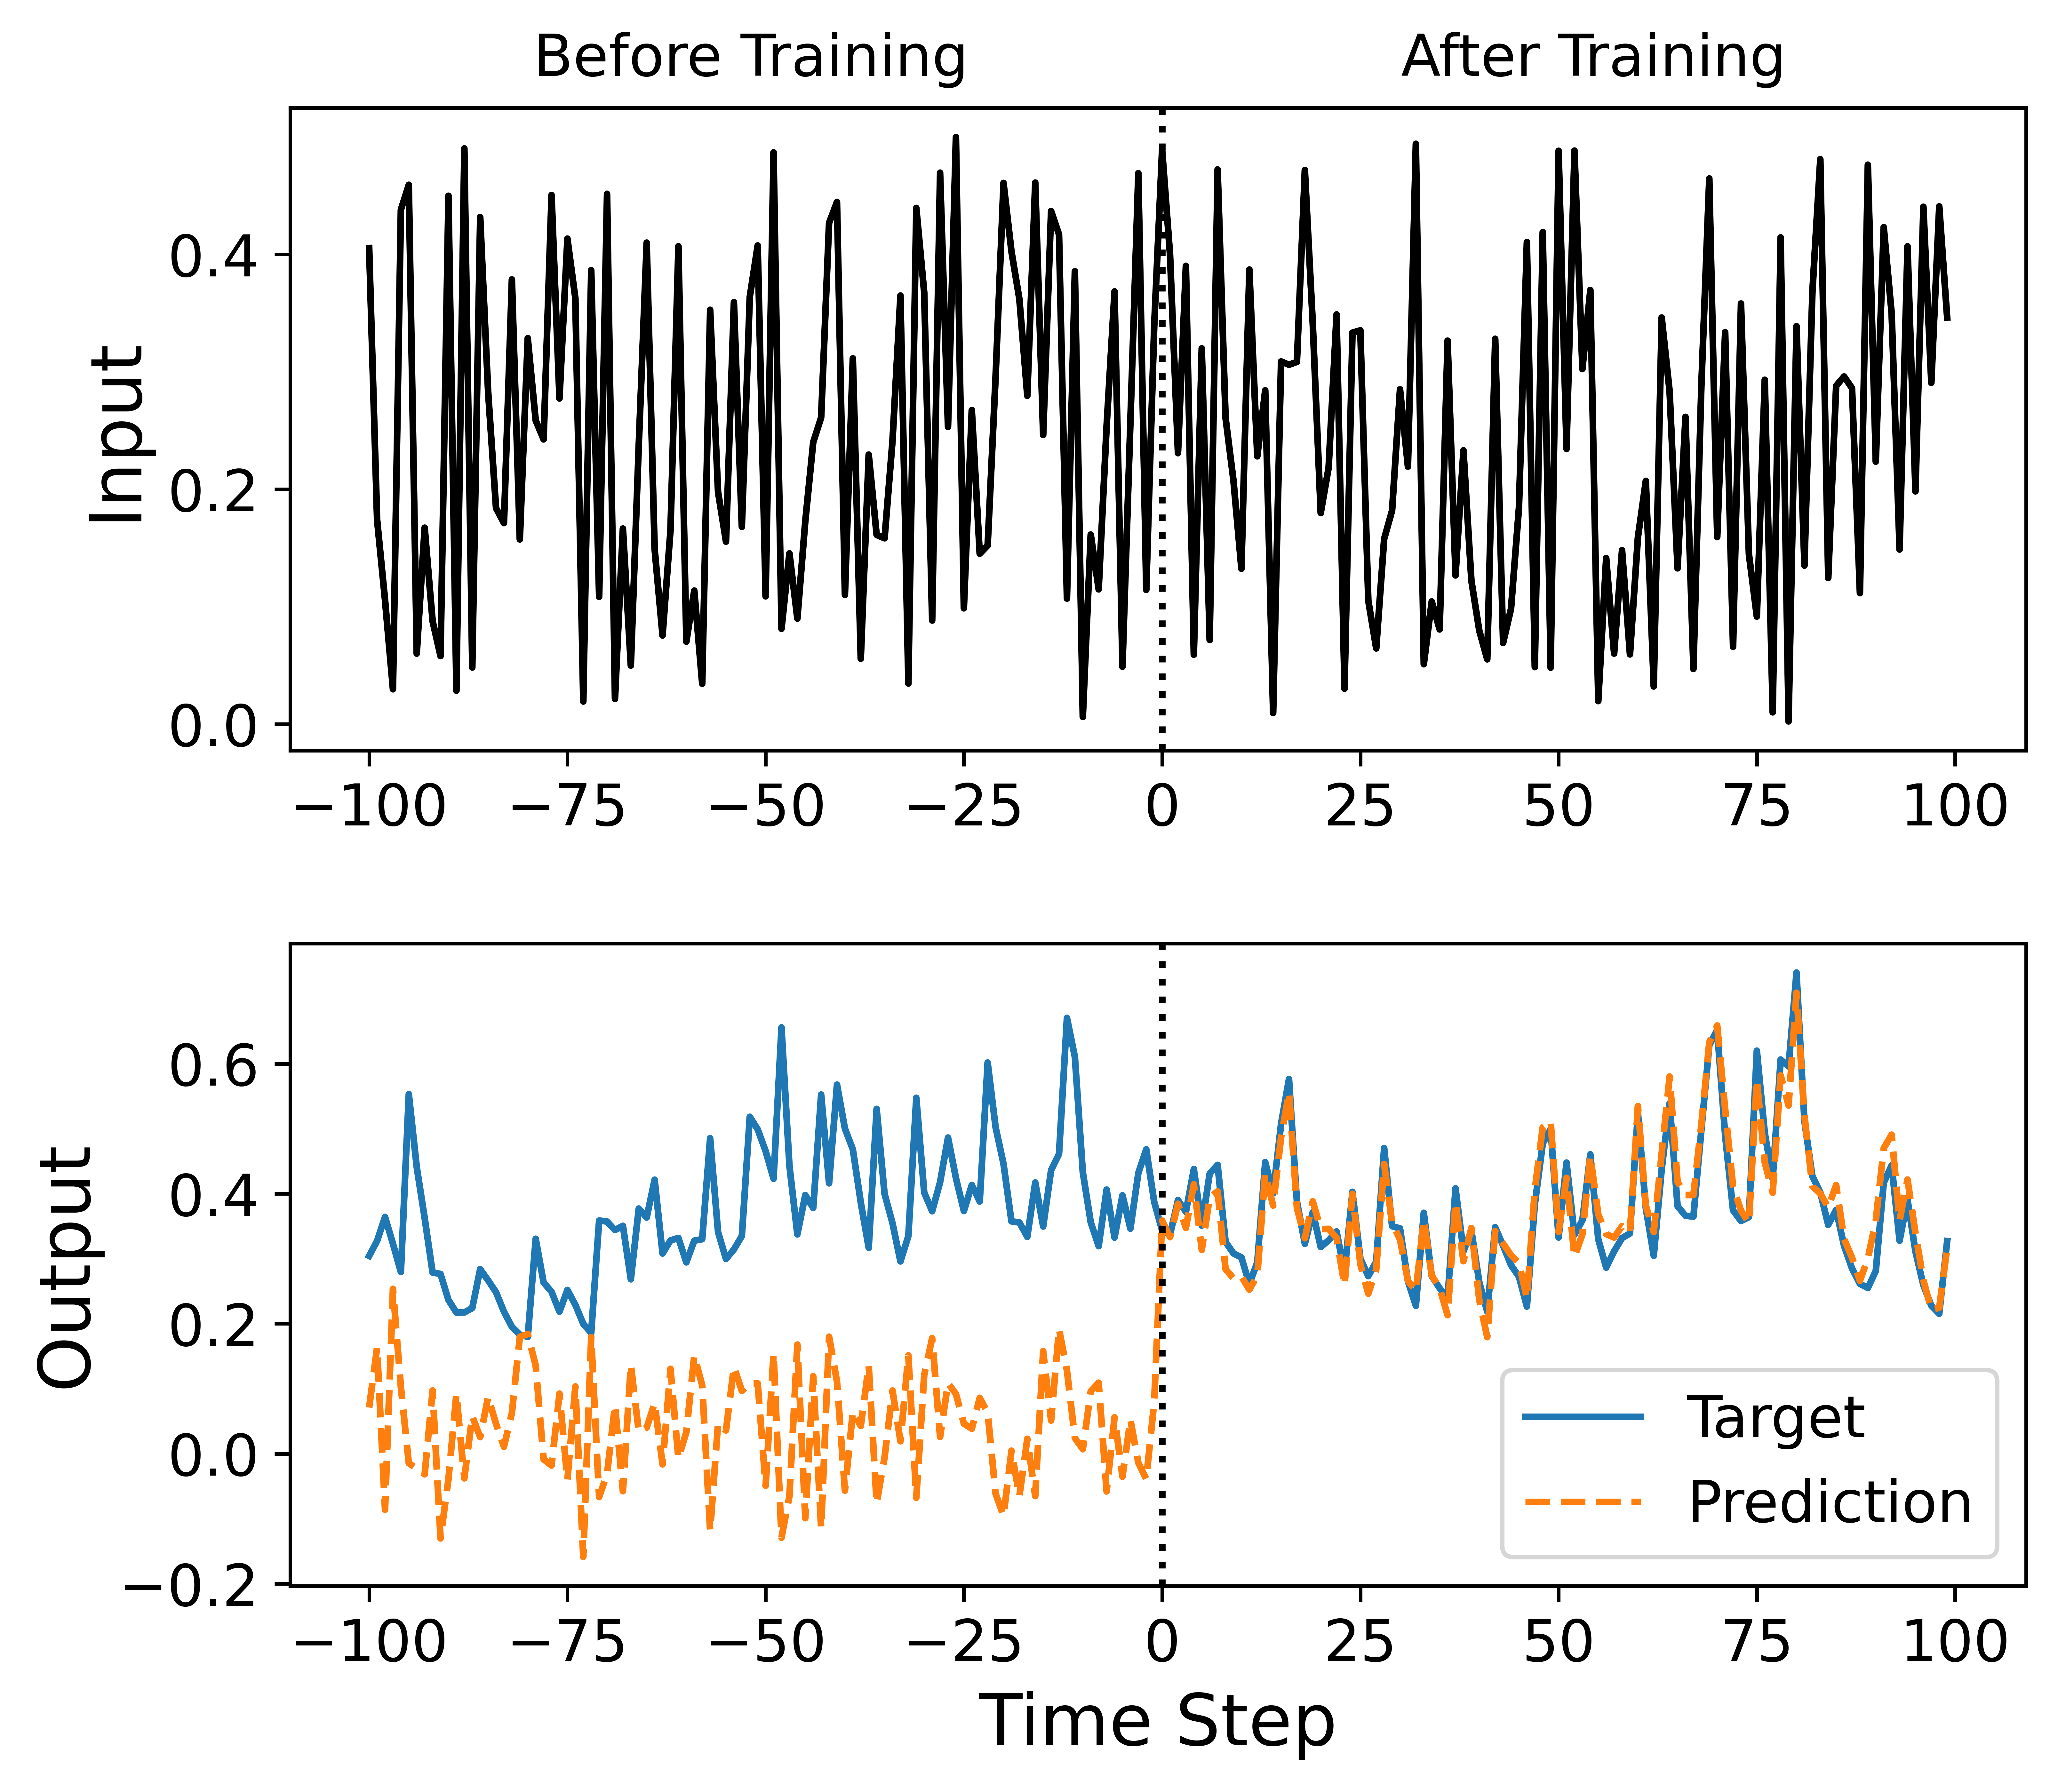

In [6]:
# グラフ表示
u = np.concatenate([u[-100:], u[n*2:100+n*2]])
d_target = np.concatenate([d_train[-100:], d_test[n*2:100+n*2]])
Y_pred = np.concatenate([Y_pred_train_random[-100:], Y_pred_test[n*2:100+n*2]])

plt.rcParams['font.size'] = 13
fig = plt.figure(figsize=(7, 6), dpi=1000)
plt.subplots_adjust(hspace=0.3)
x_range = np.arange(-100, 100)

ax1 = fig.add_subplot(2, 1, 1)
ax1.text(0.14, 1.05, 'Before Training', transform=ax1.transAxes)
ax1.text(0.64, 1.05, 'After Training', transform=ax1.transAxes)
plt.plot(x_range, u, color='black')
plt.ylabel('Input', fontsize=16)
plt.axvline(x=0, ymin=0, ymax=1, color='k', linestyle=':')

ax2 = fig.add_subplot(2, 1, 2)
plt.plot(x_range, d_target, label='Target')
plt.plot(x_range, Y_pred, linestyle='--', label='Prediction')
plt.xlabel('Time Step', fontsize=16)
plt.ylabel('Output', fontsize=16)
plt.legend(bbox_to_anchor=(1, 0), loc='lower right')
plt.axvline(x=0, ymin=0, ymax=1, color='k', linestyle=':')

plt.show()